In [104]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pprint
import random
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering,  MeanShift, estimate_bandwidth

# ignore warnings
import warnings
warnings.filterwarnings('ignore')



In [91]:
dataset = pd.read_csv("diagnosed_cbc_data_v4.csv")
# dataset.head()

In [92]:
unique_targets = set(dataset['Diagnosis'])
pprint.pprint(unique_targets)
print("Quantidade de classes únicas -> ", len(unique_targets))

{'Healthy',
 'Iron deficiency anemia',
 'Leukemia',
 'Leukemia with thrombocytopenia',
 'Macrocytic anemia',
 'Normocytic hypochromic anemia',
 'Normocytic normochromic anemia',
 'Other microcytic anemia',
 'Thrombocytopenia'}
Quantidade de classes únicas ->  9


In [93]:
for col in dataset.columns:
    try:
        if dataset[col].min() < 0:
            print(col)
    except:
        pass

HGB
MCV


In [94]:
dataset = dataset.drop(dataset[dataset['HGB'] < 0].index[0])
dataset = dataset.drop(dataset[dataset['MCV'] < 0].index[0])

In [95]:
print("Duplicações antes da exclusão: ", dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)
print("Duplicações após exclusão: ", dataset.duplicated().sum())

Duplicações antes da exclusão:  49
Duplicações após exclusão:  0


In [96]:
target = dataset['Diagnosis'].values
dataset = dataset.drop('Diagnosis', axis=1)

In [97]:
def euclidean_distance(point1, point2):
    return sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)) ** 0.5

In [98]:
def kmeans(df, k, max_iterations=1000): 
    points = df.values.tolist()
    centroids = random.sample(points, k)
    
    for _ in range(max_iterations):
        # Calcular as distâncias entre cada ponto e os centróides
        labels = []
        for point in points:
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            labels.append(distances.index(min(distances)))
        
        new_centroids = []
        for i in range(k):
            cluster_points = [point for point, label in zip(points, labels) if label == i]
            if cluster_points:
                new_centroid = [sum(dim) / len(cluster_points) for dim in zip(*cluster_points)]
            else:
                new_centroid = centroids[i]
            new_centroids.append(new_centroid)
        
        if new_centroids == centroids:
            break
        
        centroids = new_centroids
    
    return centroids, labels

In [99]:
def predict(new_points, centroids):
    predictions = []
    for point in new_points:
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        predictions.append(distances.index(min(distances)))
    return predictions

#### Padronizando os dados


In [100]:
mm = MinMaxScaler()
df_to_kmeans= mm.fit_transform(dataset)
dataset = pd.DataFrame(df_to_kmeans, columns=dataset.columns )

## K-Means

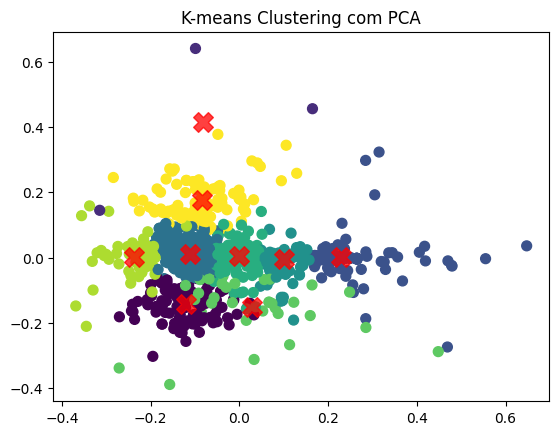

Kmeans silhouete >>  0.21491503504301968
Kmeans davies_bouldin >>  1.4702009568002339
Kmeans v_measure >>  1.0


In [65]:
k = 9
centroids, labels = kmeans(dataset, k)
y_kmeans = predict(dataset.values.tolist(), centroids)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(dataset)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = pca.transform(centroids)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-means Clustering com PCA')
plt.show()

coeficiente_silhueta = silhouette_score(dataset, labels)
davies_bouldin = davies_bouldin_score(dataset, labels)
v_measure = v_measure_score(labels, y_kmeans)
print("Kmeans silhouete >> ", coeficiente_silhueta)
print("Kmeans davies_bouldin >> ", davies_bouldin)
print("Kmeans v_measure >> ", v_measure)

## Affinity Propagation

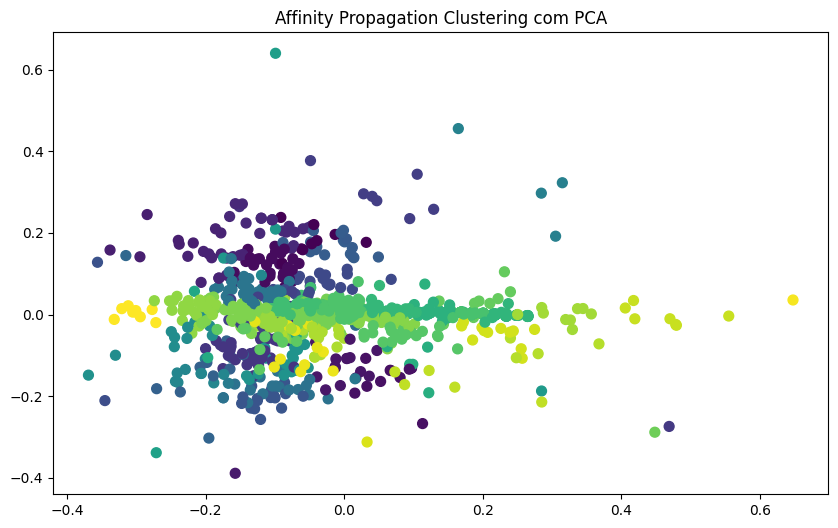

Affinity Propagation silhouete >>  0.21000260214081454
Affinity Propagation davies_bouldin >>  0.8223438581341334
Affinity Propagation v_measure >>  0.28762776469724993


In [101]:
affinity_p = AffinityPropagation(damping=0.5)
labels = affinity_p.fit_predict(dataset)

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(dataset)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis')
plt.title('Affinity Propagation Clustering com PCA')
plt.show()

coeficiente_silhueta = silhouette_score(dataset, labels)
davies_bouldin = davies_bouldin_score(dataset, labels)
v_measure = v_measure_score(target, labels)

print("Affinity Propagation silhouete >> ", coeficiente_silhueta)
print("Affinity Propagation davies_bouldin >> ", davies_bouldin)
print("Affinity Propagation v_measure >> ", v_measure)

## Mean Shift

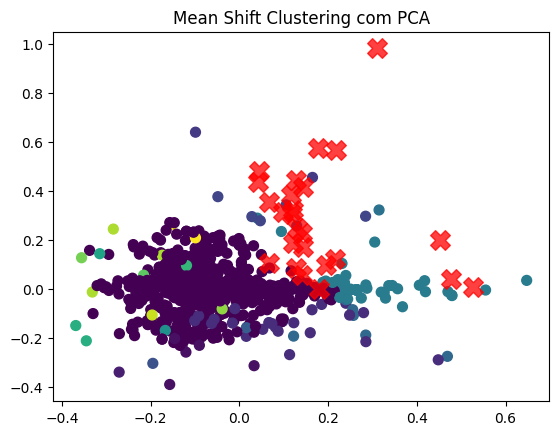

Mean Shift silhouete >>  0.18698579193536344
Mean Shift davies_bouldin >>  0.7100892539077897
Mean Shift v_measure >>  0.08971576806492429


In [102]:
bandwidth = estimate_bandwidth(dataset, quantile=0.2, n_samples=500)

# Aplicar Mean Shift
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels = mean_shift.fit_predict(dataset)
cluster_centers = mean_shift.cluster_centers_

pca = PCA(n_components=2)
df_pca = pca.fit_transform(dataset)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, s=50, cmap='viridis')
centers = pca.transform(centroids)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('Mean Shift Clustering com PCA')
plt.show()

coeficiente_silhueta = silhouette_score(dataset, labels)
davies_bouldin = davies_bouldin_score(dataset, labels)
v_measure = v_measure_score(target, labels)

print("Mean Shift silhouete >> ", coeficiente_silhueta)
print("Mean Shift davies_bouldin >> ", davies_bouldin)
print("Mean Shift v_measure >> ", v_measure)

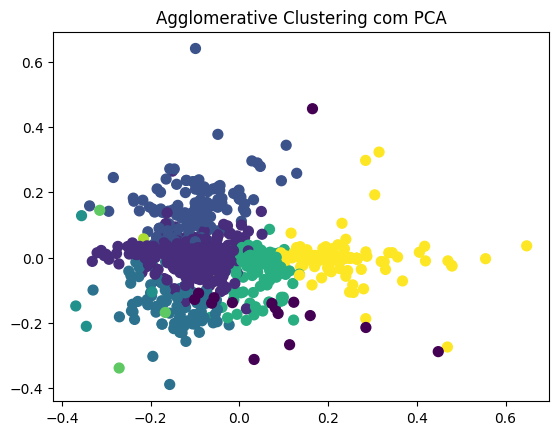

Agglomerative Clustering silhouete >>  0.26972895281914433
Agglomerative Clustering davies_bouldin >>  1.0737522544947562
Agglomerative Clustering v_measure >>  0.18291545161550543


In [105]:
## Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=9)
labels = agglomerative.fit_predict(dataset)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(dataset)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, s=50, cmap='viridis')
plt.title('Agglomerative Clustering com PCA')
plt.show()

coeficiente_silhueta = silhouette_score(dataset, labels)
davies_bouldin = davies_bouldin_score(dataset, labels)
v_measure = v_measure_score(target, labels)

print("Agglomerative Clustering silhouete >> ", coeficiente_silhueta)
print("Agglomerative Clustering davies_bouldin >> ", davies_bouldin)
print("Agglomerative Clustering v_measure >> ", v_measure)


Referências
- https://geeksforgeeks.org/clustering-metrics/
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans
- https://medium.com/@kalimarapeleteiro/m%C3%A9tricas-de-agrupamento-coeficiente-de-silhueta-%C3%ADndice-de-davies-bouldin-e-%C3%ADndice-de-9462b87ce676
